# Down-scaled multi-area model

<img src="model_construction.png" alt="Model overview" width="1000"/>

The code in this notebook implements the down-scaled version of spiking network model of macaque visual cortex developed at the Institute of Neuroscience and Medicine (INM-6), Research Center Jülich. The full-scale model has been documented in the following publications:

1. Schmidt M, Bakker R, Hilgetag CC, Diesmann M & van Albada SJ
   Multi-scale account of the network structure of macaque visual cortex
   Brain Structure and Function (2018), 223: 1409 [https://doi.org/10.1007/s00429-017-1554-4](https://doi.org/10.1007/s00429-017-1554-4)

2. Schuecker J, Schmidt M, van Albada SJ, Diesmann M & Helias M (2017)
   Fundamental Activity Constraints Lead to Specific Interpretations of the Connectome.
   PLOS Computational Biology, 13(2): e1005179. [https://doi.org/10.1371/journal.pcbi.1005179](https://doi.org/10.1371/journal.pcbi.1005179)

3. Schmidt M, Bakker R, Shen K, Bezgin B, Diesmann M & van Albada SJ (2018)
   A multi-scale layer-resolved spiking network model of
   resting-state dynamics in macaque cortex. PLOS Computational Biology, 14(9): e1006359. [https://doi.org/10.1371/journal.pcbi.1006359](https://doi.org/10.1371/journal.pcbi.1006359)
<br>

#### Notebook structure <a class="anchor" id="toc"></a>
* [S0. Configuration](#section_0)
* [S1. Parameterization](#section_1)
    * [1.1. Parameters to tune](#section_1_1)
    * [1.2. Default parameters](#section_1_2)
* [S2. Multi-Area Model Instantiation and Simulation](#section_2)
    * [2.1. Instantiate a multi-area model](#section_2_1)
    * [2.2. Predict firing rates from theory](#section_2_2)
    * [2.3. Extract and visualize interareal connectivity](#section_2_3)
    * [2.4. Run a simulation](#section_2_4)
* [S3. Simulation Results Visualization](#section_3) 
    * [3.1. Instantaneous and mean firing rate across all populations](#section_3_1)
    * [3.2. Resting state plots](#section_3_2)
    * [3.3. Time-averaged population rates](#section_3_3)

## S0. Configuration <a class="anchor" id="section_0"></a>

In [1]:
# Create config file
with open('config.py', 'w') as fp:
    fp.write(
'''import os
base_path = os.path.abspath(".")
data_path = os.path.abspath("simulations")
jobscript_template = "python {base_path}/run_simulation.py {label}"
submit_cmd = "bash -c"
''')

In [2]:
%matplotlib inline
import numpy as np
import os
import nest
import json
import sys
from IPython.display import display, HTML
import warnings

from multiarea_model import MultiAreaModel
from config import base_path, data_path

sys.path.append('./figures/MAM2EBRAINS')
from M2E_visualize_interareal_connectivity import visualize_interareal_connectivity
from M2E_visualize_firing_rates import plot_instan_mean_firing_rate
from M2E_visualize_resting_state import plot_resting_state
from M2E_visualize_time_ave_pop_rates import plot_time_averaged_population_rates


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Oct 15 2023 15:12:16

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
# %%capture captured
# !pip install nested_dict dicthash

In [4]:
# Jupyter notebook display format setting
style = """
<style>
table {float:left}
</style>
"""
display(HTML(style))

warnings.filterwarnings('ignore')

Go back to [Notebook structure](#toc)

## S1. Parameterization <a class="anchor" id="section_1"></a>

### 1.1. Parameters to tune <a class="anchor" id="section_1_1"></a>

|Parameter|Default value|Value range/options|Value assigned|Description|
|:-------:|:-----------:|:-----------------:|:------------:|:---------:|
|scale_down_to|1.       |(0, 1.0]           |0.005         |$^1$       |
|cc_weights_factor|1.   |[1.0, 2.5]         |1.            |$^2$       |
|areas_simulated|complete_area_list|Sublists of complete_area_list|complete_area_list|$^3$|
|replace_non_simulated_areas|None|None, 'hom_poisson_stat', 'het_poisson_stat', 'het_current_nonstat'|'het_poisson_stat'|$^4$ |

1. `scale_down_to` is the down-scaling factor that defines the ratio by which the full-scale multi-area model is reduced to a model with fewer neurons and indegrees. This reduction is essential to enable simulation on machines with limited computational power, ensuring that simulation results can be obtained in a relatively shorter timeframe. <br> If the value is `scale_down_to = 1.`, the full-scale network will be simulated. <br> In the pre-set downscale version, it is set to `scale_down_to = 0.005`, This setting reduces both the number of neurons and indegrees to 0.5 % of their full-scale counterparts, facilitating simulation on a typical local machine. <br> **Warning**: This will not yield reasonable dynamical results from the network and is only meant to demonstrate the simulation workflow <br> 

2. `cc_weights_factor` is the scaling factor that controls the cortico-cortical synaptic strength. <br> By default it's set as `1.0`, where the inter-area synaptic strength is the same as the intra-areal. <br> **Important**: This factor changes the network activity from ground state to metastable state. <br>

3. `areas_simulated` specifies the cortical areas to be included in the simulation process. Its default value is `complete_area_list` meaning all the areas in the complete_area_list will be simulated. The value assigned to `areas_simulated` can be any sublist of the list below:
```python
complete_area_list = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH']
```
<br>

4. `replace_non_simulated_areas` defines how non-simulated areas will be replaced. <br> When all areas are included, it is set as `None` by default. <br> Other options are: `'hom_poisson_stat'`, `'het_poisson_stat'`, and `'het_current_nonstat'`.<br> `'hom_poisson_stat'` replaces the non-simulated areas by Poisson sources with the same global rate `rate_ext`. The `'het_poisson_stat'` and `'het_current_nonstat'` options use the loaded specific rates from `'replace_cc_input_source'`, which contains the area-specific firing rates of our full scale simulation results. The difference between them is that `'het_poisson_stat'` replaces the non-simulated areas by Poisson spike trains and `'het_current_nonstat'` replaces it by a time-varying current input.

In [5]:
# Downscaling factor
# Value range/options: (0, 1.]
# Value assigned: 0.005
scale_down_to = 0.005 # Change it to 1. for running the fullscale network

# Scaling factor for cortico-cortical connections (chi) 
# Value range/options: [1., 2.5]
# Value assigned: 1.0
cc_weights_factor = 1.0

# Cortical areas included in the simulation
# Value range/options: any sublist of complete_area_list
# where complete_area_list = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH']
# Value assigned: complete_area_list
# Note: at this pre-released multi-area model v2.0.0, the areas_similated has to be complete_area_list
areas_simulated = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH']
# areas_simulated = ['V1', 'V2']

# Firing rates used to replace the non-simulated areas
# Value range/options: None, 'hom_poisson_stat', 'het_poisson_stat', 'het_current_nonstat'
# Value assigned: 'het_poisson_stat'
replace_non_simulated_areas = 'het_poisson_stat'

### 1.2. Default parameters <a class="anchor" id="section_1_2"></a>
We try our best not to confuse users with too many parameters. However, if you want to change more parameters and explore the model, you can do so by passing a dictionary to the `default_params` argument of the `MultiAreaModel` class. (*NOTE: it should may be moved to the default parameters file in the future.*)

In [6]:
# Decide the parameter replace_cc_input_source
complete_area_list = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH']

if areas_simulated != complete_area_list and replace_non_simulated_areas == None:
    raise Exception("When not all areas are simulated, a not None value should be assigned to replace_non_simulated_areas!")
elif replace_non_simulated_areas == 'hom_poisson_stat':
    replace_cc_input_source = None
else:
    replace_cc_input_source = 'tests/fullscale_rates.json'

# Connection parameters
conn_params = {
    'replace_non_simulated_areas': replace_non_simulated_areas, # Whether to replace non-simulated areas by Poisson sources with the same global rate, by default: None
    'g': -11., # It sets the relative inhibitory synaptic strength, by default: -16.
    'K_stable': 'K_stable.npy', # Whether to apply the stabilization method of Schuecker, Schmidt et al. (2017), by default: None
    'fac_nu_ext_TH': 1.2, # Increase the external input to 2/3E and 5E in area TH
    'fac_nu_ext_5E': 1.125, # Increase the external Poisson indegree onto 5E
    'fac_nu_ext_6E': 1.41666667, # Increase the external Poisson indegree onto 6E
    'av_indegree_V1': 3950., # Adjust the average indegree in V1 based on monkey data
    'replace_cc_input_source': replace_cc_input_source
}

# Input parameters
input_params = {
    'rate_ext': 10. # Rate of the Poissonian spike generator (in spikes/s)
} 

# Neuron parameters
neuron_params = {
    'V0_mean': -150., # Mean for the distribution of initial membrane potentials, by default: -100.
    'V0_sd': 50. # Standard deviation for the distribution of initial membrane potentials, by default: 50.
}

# Network parameters
network_params = {
    'N_scaling': scale_down_to, # Scaling of population sizes, by default: 1.
    'K_scaling': scale_down_to, # Scaling of indegrees, by default: 1.
    'fullscale_rates': 'tests/fullscale_rates.json', # Absolute path to the file holding full-scale rates for scaling synaptic weights, by default: None
    'input_params': input_params, # Input parameters
    'connection_params': conn_params, # Connection parameters
    'neuron_params': neuron_params # Neuron parameters
} 

# Simulation parameters
sim_params = {
    'areas_simulated': areas_simulated,
    't_sim': 2000., # Simulated time (in ms), by default: 10.0
    'num_processes': 1, # The number of MPI processes, by default: 1
    'local_num_threads': 1, # The number of threads per MPI process, by default: 1
    'recording_dict': {'record_vm': False},
    'rng_seed': 1  # global random seed
}

# Theory paramters (theory_params)
theory_params = {
    'dt': 0.1 # The time step of the mean-field theory integration, by default: 0.01
} 

Go back to [Notebook structure](#toc)

## S2. Multi-Area Model Instantiation and Simulation <a class="anchor" id="section_2"></a>

### 2.1. Instantiate a multi-area model <a class="anchor" id="section_2_1"></a>

In [7]:
%%capture captured
M = MultiAreaModel(network_params, 
                   simulation=True,
                   sim_spec=sim_params,
                   theory=True,
                   theory_spec=theory_params)

### 2.2. Predict firing rates from theory <a class="anchor" id="section_2_2"></a>

In [8]:
p, r = M.theory.integrate_siegert()
print("Mean-field theory predicts an average "
      "firing rate of {0:.3f} spikes/s across all populations.".format(np.mean(r[:, -1])))

Iteration: 0
Mean-field theory predicts an average firing rate of 29.588 spikes/s across all populations.


### 2.3. Extract and visualize interareal connectivity <a class="anchor" id="section_2_3"></a>

The connectivity and neuron numbers are stored in the attributes of the model class. Neuron numbers are stored in `M.N` as a dictionary (and in `M.N_vec` as an array), indegrees in `M.K` as a dictionary (and in `M.K_matrix` as an array). Number of synapses can also be access via `M.synapses` (and in `M.syn_matrix` as an array). <br>

In [9]:
# Neuron numbers

# Dictionary of neuron numbers
# print(M.N)

# Array of neuron numbers
# (M.N_vec)

In [10]:
# Indegrees

# Dictionary of nodes indegrees organized as:
# {<source_area>: {<source_pop>: {<target_area>: {<target_pop>: indegree_values}}}}
# M.K

# Array of nodes indegrees
# M.K_matrix.shape

In [11]:
# Synapses

# Dictionary of synapses that target neurons receive, it is organized as:
# {<source_area>: {<source_pop>: {<target_area>: {<target_pop>: number_of_synapses}}}}
# M.synapses

# Array of 
# M.syn_matrix

Initializing network from dictionary.
RAND_DATA_LABEL 961


Customized parameters
--------------------
{}


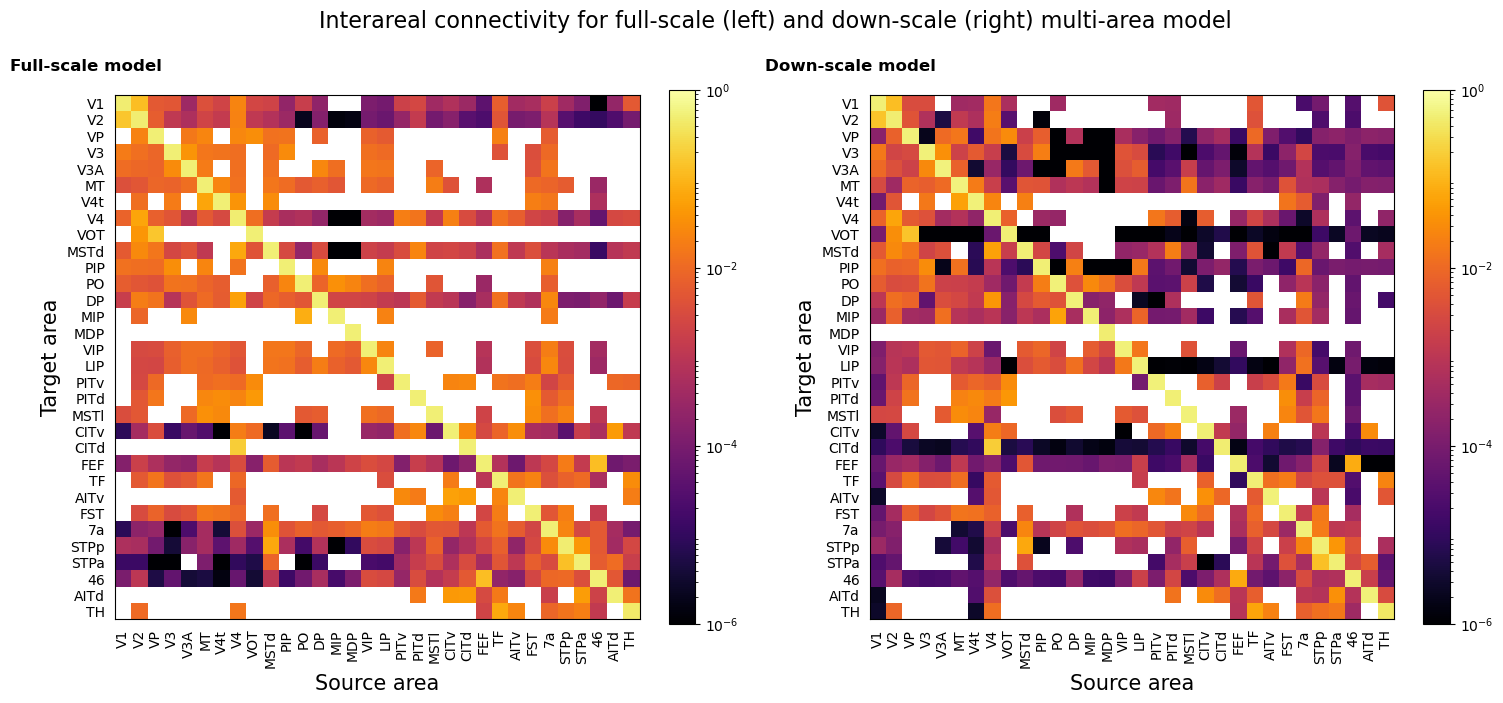

In [12]:
visualize_interareal_connectivity(M)

Comparable figure in our publications: <br>
1. Schmidt M, Bakker R, Hilgetag CC, Diesmann M & van Albada SJ <br>
   Multi-scale account of the network structure of macaque visual cortex
   Brain Structure and Function (2018), 223: 1409 [https://doi.org/10.1007/s00429-017-1554-4](https://doi.org/10.1007/s00429-017-1554-4) <br>
   **Fig. 4 D Area-level connectivity of the model, based on data in a–c, expressed as relative indegrees for each target area**

Go back to [Notebook structure](#toc)

### 2.4. Run a simulation <a class="anchor" id="section_2_4"></a>

In [13]:
# %%capture captured
# run the simulation, depending on the model parameter and downscale ratio, the running time varies largely.
M.simulation.simulate()

Prepared simulation in 0.01 seconds.
Rank 0: created area V1 with 0 local nodes
Memory after V1 : 1587.97 MB
Rank 0: created area V2 with 0 local nodes
Memory after V2 : 1614.52 MB
Rank 0: created area VP with 0 local nodes
Memory after VP : 1643.68 MB
Rank 0: created area V3 with 0 local nodes
Memory after V3 : 1671.91 MB
Rank 0: created area V3A with 0 local nodes
Memory after V3A : 1691.91 MB
Rank 0: created area MT with 0 local nodes
Memory after MT : 1717.40 MB
Rank 0: created area V4t with 0 local nodes
Memory after V4t : 1742.35 MB
Rank 0: created area V4 with 0 local nodes
Memory after V4 : 1769.39 MB
Rank 0: created area VOT with 0 local nodes
Memory after VOT : 1794.61 MB
Rank 0: created area MSTd with 0 local nodes
Memory after MSTd : 1816.05 MB
Rank 0: created area PIP with 0 local nodes
Memory after PIP : 1837.43 MB
Rank 0: created area PO with 0 local nodes
Memory after PO : 1858.76 MB
Rank 0: created area DP with 0 local nodes
Memory after DP : 1879.01 MB
Rank 0: created

Go back to [Notebook structure](#toc)

## S3. Simulation Results Visualization <a class="anchor" id="section_3"></a>

### 3.1. Instantaneous and mean firing rate across all populations <a class="anchor" id="section_3_1"></a>

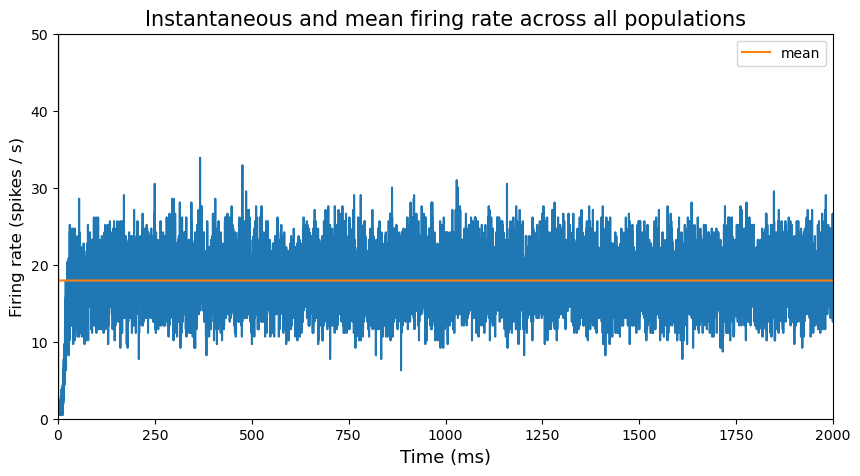

In [14]:
plot_instan_mean_firing_rate(M)

### 3.2 Resting state plots <a class="anchor" id="section_3_2"></a>

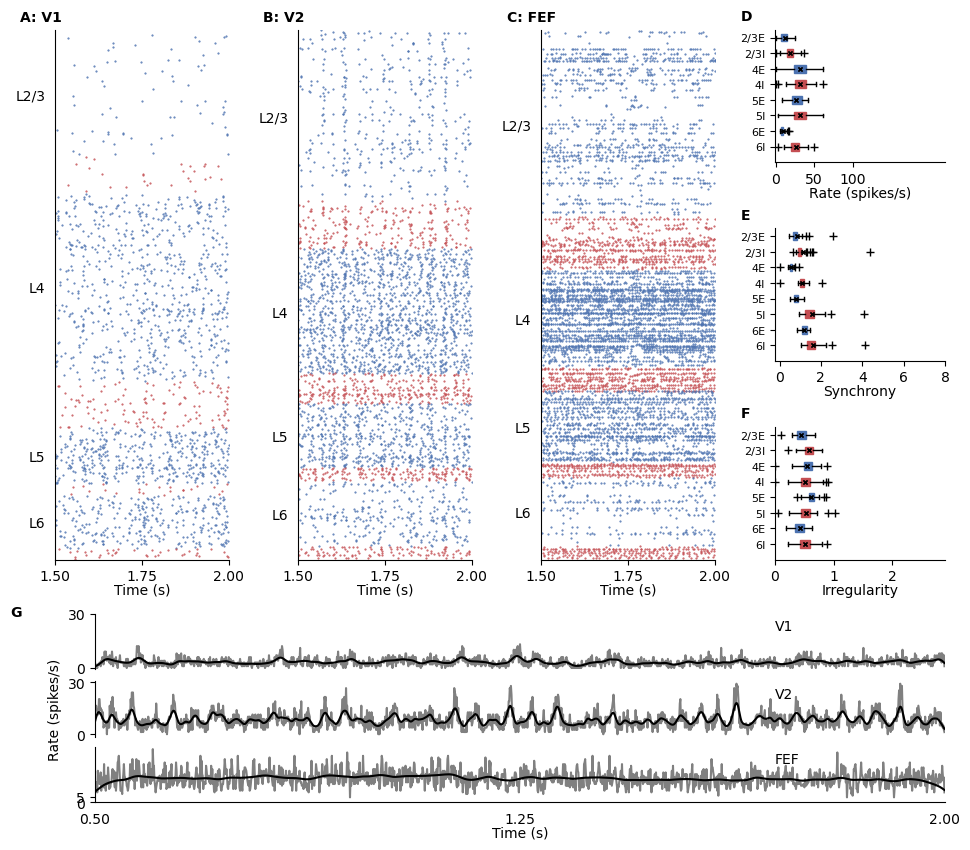

In [15]:
# Choose 3 areas from the complete_area_list to show their sipking activity
# By default, it's set as ['V1', 'V2', 'FEF']
# Note: at this pre-released multi-area model v2.0.0, the areas_similated has to be 
raster_areas = ['V1', 'V2', 'FEF']
plot_resting_state(M, data_path, raster_areas)

Comparable figure in our publications: <br>
1. Schmidt M, Bakker R, Shen K, Bezgin B, Diesmann M & van Albada SJ (2018)
   A multi-scale layer-resolved spiking network model of
   resting-state dynamics in macaque cortex. PLOS Computational Biology, 14(9): e1006359. [https://doi.org/10.1371/journal.pcbi.1006359](https://doi.org/10.1371/journal.pcbi.1006359) <br>
   **Fig 3.  Ground state of the model.**

### 3.3 Time-averaged population rates <a class="anchor" id="section_4_3"></a>
An overview over time-averaged population rates encoded in colors with areas along x-axis and populations along y-axis.

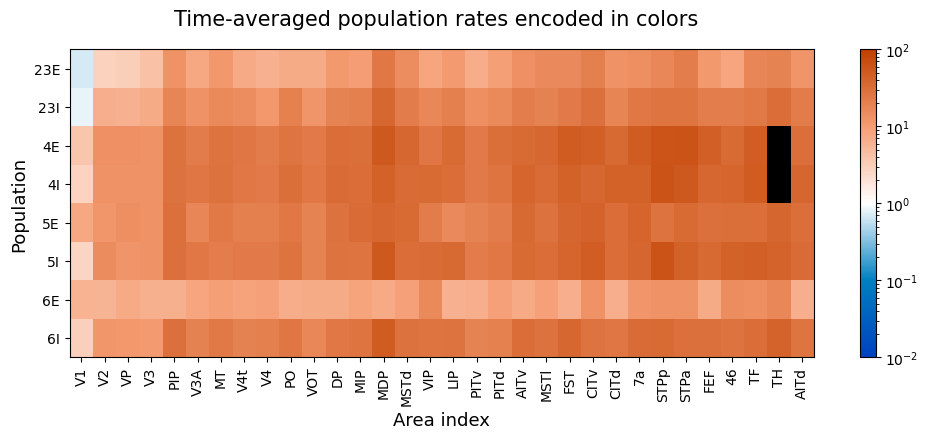

In [16]:
plot_time_averaged_population_rates(M)

Go back to [Notebook structure](#toc)